Transfer learning for COVID-19 diagnosis using CT images 

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader as torch_dataloader
from torch.utils.data import Dataset as torch_dataset

In [3]:
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [1]:
import skimage
import skimage.io as io

In [4]:
import glob

In [5]:
class MyDataset(torch_dataset):
    def __init__(self, path, filenamelist, labellist):
        self.path=path
        self.filenamelist=filenamelist
        self.labellist=labellist
    def __len__(self):
        #return the number of data points
        return len(self.filenamelist)
    def __getitem__(self, idx):
        I=io.imread(self.path+self.filenamelist[idx])
        I=skimage.util.img_as_float32(I)
        I = I.reshape(1,I.shape[0],I.shape[1])
        I = torch.tensor(I, dtype=torch.float32)
        I = I.expand(3, I.shape[1],I.shape[2])
        label=torch.tensor(self.labellist[idx], dtype=torch.int64)
        return I, label

In [6]:
def get_dataloader():
    df_train = pd.read_csv('C:/Users/Mestr/Desktop/Intro to ML and Apps/Homework/hw5s/hw5s/COVID19CTS224/S224/train.csv')
    path = 'C:/Users/Mestr/Desktop/Intro to ML and Apps/Homework/hw5s/hw5s/COVID19CTS224/S224/'
    dataset_train = MyDataset(path, df_train['filename'].values, df_train['label'].values)
    loader_train = torch_dataloader(dataset_train, batch_size=32, num_workers=0, shuffle=True, pin_memory=True)
    
    return loader_train

In [8]:
# Construct a CNN by modifying Resnet-18 or Resnet-50 for binary classification
def modify_resnet_for_binary_classification(resnet_type='resnet18'):
    if resnet_type == 'resnet18':
        model = models.resnet18(pretrained=False)
    elif resnet_type == 'resnet50':
        model = models.resnet50(pretrained=False)
    else:
        raise ValueError('Invalid resnet_type. Choose "resnet18" or "resnet50".')

    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 2)
    return model

model = modify_resnet_for_binary_classification(resnet_type='resnet18')

In [9]:
#Check the true path directory
import os

file_path = 'C:/Users/Mestr/Desktop/Intro to ML and Apps/Homework/hw5s/hw5s/COVID19CTS224/S224/train.csv'
if os.path.exists(file_path):
    print("File exists.")
else:
    print("File not found.") 

File exists.


In [10]:
# Function to train the model - model (2)
def train_model(model, criterion, optimizer, dataloader, device, num_epochs=20): 
    model.to(device)
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)

        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')

    return model

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loader_train = get_dataloader()

model_normal = train_model(model, criterion, optimizer, loader_train, device)

C:\Users\Mestr\AppData\Local\Temp\ipykernel_1380\4273934899.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label=torch.tensor(self.labellist[idx], dtype=torch.int64)


Epoch 0/19, Loss: 0.4141, Acc: 0.8234
Epoch 1/19, Loss: 0.2090, Acc: 0.9204
Epoch 2/19, Loss: 0.1125, Acc: 0.9575
Epoch 3/19, Loss: 0.1186, Acc: 0.9520
Epoch 4/19, Loss: 0.1108, Acc: 0.9604
Epoch 5/19, Loss: 0.0997, Acc: 0.9609
Epoch 6/19, Loss: 0.0634, Acc: 0.9773
Epoch 7/19, Loss: 0.0184, Acc: 0.9951
Epoch 8/19, Loss: 0.0044, Acc: 1.0000
Epoch 9/19, Loss: 0.0055, Acc: 0.9985
Epoch 10/19, Loss: 0.0087, Acc: 0.9970
Epoch 11/19, Loss: 0.0042, Acc: 0.9990
Epoch 12/19, Loss: 0.0905, Acc: 0.9688
Epoch 13/19, Loss: 0.0348, Acc: 0.9881
Epoch 14/19, Loss: 0.0603, Acc: 0.9758
Epoch 15/19, Loss: 0.0483, Acc: 0.9802
Epoch 16/19, Loss: 0.0384, Acc: 0.9857
Epoch 17/19, Loss: 0.0204, Acc: 0.9946
Epoch 18/19, Loss: 0.0073, Acc: 0.9990
Epoch 19/19, Loss: 0.0041, Acc: 0.9990


In [20]:
#Function to train the model using transfer learning - model (3)
def transfer_learning(resnet_type='resnet18'):
    if resnet_type == 'resnet18':
        model = models.resnet18(pretrained=True)
    elif resnet_type == 'resnet50':
        model = models.resnet50(pretrained=True)
    else:
        raise ValueError('Invalid resnet_type. Choose "resnet18" or "resnet50".')

    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 2)

    return model

model_transfer = transfer_learning(resnet_type='resnet50')
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr=0.001)
criterion=nn.CrossEntropyLoss()
model_transfer = train_model(model_transfer, criterion, optimizer_transfer, loader_train, device, num_epochs=120)

c:\Users\Mestr\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mestr\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Mestr\AppData\Local\Temp\ipykernel_1380\4273934899.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label=torch.tensor(self.labellist[idx], dtype=torch.int64)


Epoch 0/119, Loss: 0.5520, Acc: 0.6924
Epoch 1/119, Loss: 0.3876, Acc: 0.8467
Epoch 2/119, Loss: 0.3595, Acc: 0.8437
Epoch 3/119, Loss: 0.3277, Acc: 0.8591
Epoch 4/119, Loss: 0.3413, Acc: 0.8412
Epoch 5/119, Loss: 0.2941, Acc: 0.8729
Epoch 6/119, Loss: 0.2787, Acc: 0.8867
Epoch 7/119, Loss: 0.2684, Acc: 0.8803
Epoch 8/119, Loss: 0.2489, Acc: 0.9031
Epoch 9/119, Loss: 0.2791, Acc: 0.8813
Epoch 10/119, Loss: 0.2546, Acc: 0.8991
Epoch 11/119, Loss: 0.2543, Acc: 0.9006
Epoch 12/119, Loss: 0.2482, Acc: 0.8952
Epoch 13/119, Loss: 0.2114, Acc: 0.9204
Epoch 14/119, Loss: 0.2336, Acc: 0.9085
Epoch 15/119, Loss: 0.2351, Acc: 0.9031
Epoch 16/119, Loss: 0.2354, Acc: 0.9016
Epoch 17/119, Loss: 0.2430, Acc: 0.8991
Epoch 18/119, Loss: 0.2274, Acc: 0.9055
Epoch 19/119, Loss: 0.2110, Acc: 0.9154
Epoch 20/119, Loss: 0.2201, Acc: 0.9110
Epoch 21/119, Loss: 0.1985, Acc: 0.9209
Epoch 22/119, Loss: 0.2148, Acc: 0.9110
Epoch 23/119, Loss: 0.2003, Acc: 0.9115
Epoch 24/119, Loss: 0.2071, Acc: 0.9164
Epoch 25/1

In [21]:
df_test = pd.read_csv('C:/Users/Mestr/Desktop/Intro to ML and Apps/Homework/hw5s/hw5s/COVID19CTS224/S224/test.csv')
path = 'C:/Users/Mestr/Desktop/Intro to ML and Apps/Homework/hw5s/hw5s/COVID19CTS224/S224/'
dataset_test = MyDataset(path, df_test['filename'].values, df_test['label'].values)
loader_test = torch_dataloader(dataset_test, batch_size=32, num_workers=0, shuffle=True, pin_memory=True)

In [22]:
#Function to test the model
def cal_accuracy(confusion):
    #input: confusion is the confusion matrix
    #output: acc is the standard classification accuracy
    M=confusion.copy().astype('float32')
    acc = M.diagonal().sum()/M.sum()    
    sens=np.zeros(M.shape[0])
    prec=np.zeros(M.shape[0]) 
    for n in range(0, M.shape[0]):
        TP=M[n,n]
        FN=np.sum(M[n,:])-TP
        FP=np.sum(M[:,n])-TP
        sens[n]=TP/(TP+FN)
        prec[n]=TP/(TP+FP)       
    return acc, sens, prec

def test(model, device, dataloader):
    model.eval()#set model to evaluation mode
    acc_test =0
    confusion=np.zeros((5,5))
    with torch.no_grad(): # tell Pytorch not to build graph in the with section
        for batch_idx, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            Z = model(X)#forward pass
            #do not need softmax
            Yp = Z.data.max(dim=1)[1]  # get the index of the max 
            acc_test+= torch.sum(Yp==Y).item()
            for i in range(0, 5):
                for j in range(0, 5):
                    confusion[i,j]+=torch.sum((Y==i)&(Yp==j)).item()
    acc, sens, prec=cal_accuracy(confusion)
    return acc, (confusion, sens, prec)

In [23]:
#TEST MODEL 2 AND MODEL 3

acc, (confusion, sens, prec) = test(model_normal, device, loader_test)
test_acc_normal= acc
print('Normal model Accuracy (average)', test_acc_normal) # First got an accuracy of 0.92 using 25 Epochs using SGD and Learning rate 0.001 
#Reduced the number of epochs to 20 and changed the optimizer to Adam to be more time efficient and learning rate was 0.0002. (Only used Resnet-18).

acc, (confusion, sens, prec) = test(model_transfer, device, loader_test)
test_acc_transfer= acc
print('Transfer model Accuracy (average)', test_acc_transfer) # Using Resnet-18, first got an accuracy of 0.87 using 25 Epochs using SGD and lr of 0.001. changed to Adam and Resnet-50 and got 0.89
# I will be increasing the number of epochs for better convergence and estimation, since only cpu is available it may be really time consuming.

C:\Users\Mestr\AppData\Local\Temp\ipykernel_1380\4273934899.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label=torch.tensor(self.labellist[idx], dtype=torch.int64)
C:\Users\Mestr\AppData\Local\Temp\ipykernel_1380\879820739.py:13: RuntimeWarning: invalid value encountered in float_scalars
  sens[n]=TP/(TP+FN)
C:\Users\Mestr\AppData\Local\Temp\ipykernel_1380\879820739.py:14: RuntimeWarning: invalid value encountered in float_scalars
  prec[n]=TP/(TP+FP)


Normal model Accuracy (average) 0.94
Transfer model Accuracy (average) 0.9025


In [14]:
# Break down of the two models, transfer learning for this application requires more computations to get a better estimate when compararing with the model from scratch, therefore just using the scrach model 
# we should have accurate results for less computation time.

In [15]:
import argparse

In [16]:
import cv2

In [17]:
from pytorch_grad_cam import GradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image

In [18]:
from PIL import Image
import torchvision.transforms as transforms

In [19]:
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [24]:
def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--use-cuda', action='store_true', default=False,
                        help='Use NVIDIA GPU acceleration')
    parser.add_argument(
        '--image-path',
        type=str,
        default='C:/Users/Mestr/Desktop/Intro to ML and Apps/Homework/hw5s/hw5s/COVID19CTS224/S224/COVID/Covid (1).png',
        help='Input image path')
    parser.add_argument(
        '--excel-path',
        type=str,
        default='C:/Users/Mestr/Desktop/Intro to ML and Apps/Homework/hw5s/hw5s/COVID19CTS224/S224/test.csv',
        help='Path to the Excel file containing the test set')
    parser.add_argument('--aug_smooth', action='store_true',
                        help='Apply test time augmentation to smooth the CAM')
    parser.add_argument(
        '--eigen_smooth',
        action='store_true',
        help='Reduce noise by taking the first principle componenet'
        'of cam_weights*activations')
    parser.add_argument('--method', type=str, default='gradcam',
                        choices=['gradcam', 'eigencam'])

    args = parser.parse_args()
    args.use_cuda = args.use_cuda and torch.cuda.is_available()
    if args.use_cuda:
        print('Using GPU for acceleration')
    else:
        print('Using CPU for computation')

    return args

model_2 = model_normal
model_3= model_transfer

In [25]:
#Model 2 for GradCam Test Set

class Args:
    def __init__(self):
        self.use_cuda = False
        self.image_path = 'C:/Users/Mestr/Desktop/Intro to ML and Apps/Homework/hw5s/hw5s/COVID19CTS224/S224/COVID/Covid (1).png'
        self.csv_path = 'C:/Users/Mestr/Desktop/Intro to ML and Apps/Homework/hw5s/hw5s/COVID19CTS224/S224/test.csv'
        self.aug_smooth = False
        self.eigen_smooth = False
        self.method = 'gradcam'

args = Args()
methods ={"gradcam": GradCAM,
         "eigencam": EigenCAM}

# Load the CSV file
test_images = args.csv_path
df = pd.read_csv(test_images)

# Choose the target layer you want to compute the visualization for.
    # Usually this will be the last convolutional layer in the model.
    # Some common choices can be:
    # Resnet18 and 50: model.layer4
    # VGG, densenet161: model.features[-1]
    # mnasnet1_0: model.layers[-1]
    # You can print the model to help chose the layer
    # You can pass a list with several target layers,
    # in that case the CAMs will be computed per layer and then aggregated.
    # You can also try selecting all layers of a certain type, with e.g:
    # from pytorch_grad_cam.utils.find_layers import find_layer_types_recursive
    # find_layer_types_recursive(model, [torch.nn.ReLU])
target_layers_model_2 = [model_2.layer4]

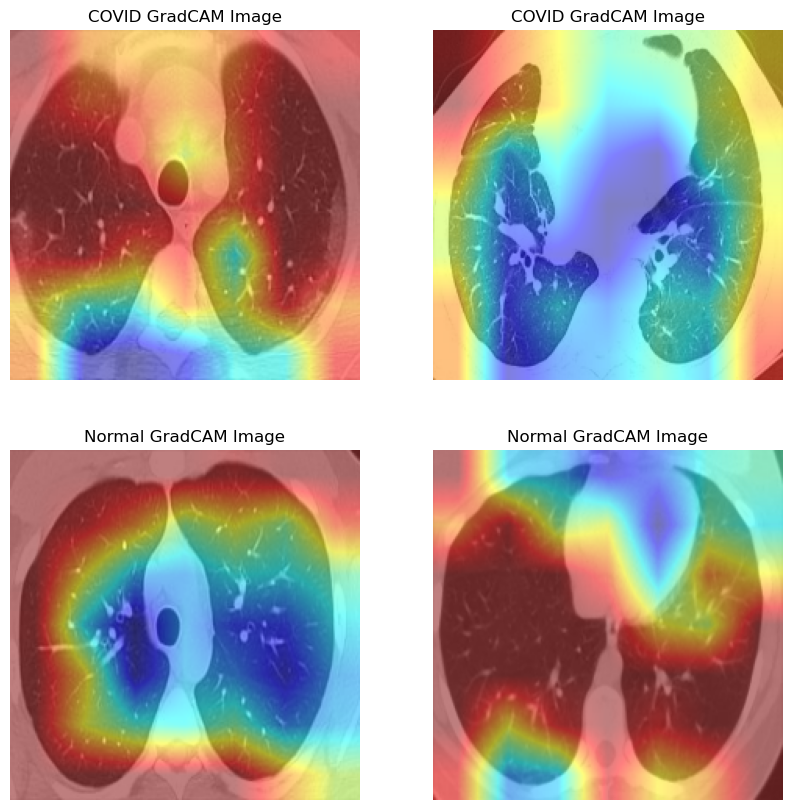

In [26]:
 # We have to specify the target we want to generate
    # the Class Activation Maps for.
    # If targets is None, the highest scoring category (for every member in the batch) will be used.
    # You can target specific categories by
    # targets = [e.g ClassifierOutputTarget(281)]
targets=None
# Decide how many images you want to display per row and column
# Separate the images based on their labels
covid_images = df[df['label'] == 1]['filename']
normal_images = df[df['label'] == 0]['filename']
rows = 2
cols = 2

# Create a figure and axes for the grid
fig, axs = plt.subplots(rows, cols, figsize=(10, 10))

# Display 2 COVID images
for col in range(cols):
    if col < len(covid_images):
        image_path = covid_images.iloc[col]

        rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
        rgb_img = np.float32(rgb_img) / 255
        input_tensor = preprocess_image(rgb_img,
                                        mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])

        # Using the with statement ensures the context is freed, and you can
        # recreate different CAM objects in a loop.
        cam_algorithm = methods[args.method]
        with cam_algorithm(model=model_2,
                        target_layers=target_layers_model_2,
                        use_cuda=args.use_cuda) as cam:

            cam.batch_size = 32
            grayscale_cam = cam(input_tensor=input_tensor,
                                targets=targets,
                                aug_smooth=args.aug_smooth,
                                eigen_smooth=args.eigen_smooth)

            grayscale_cam = grayscale_cam[0, :]
            cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
            # cam_image is RGB encoded whereas "cv2.imwrite" requires BGR encoding.
            cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)

        gb_model = GuidedBackpropReLUModel(model=model_2, use_cuda=args.use_cuda)
        gb = gb_model(input_tensor, target_category=None)

        cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
        cam_gb = deprocess_image(cam_mask * gb)
        gb = deprocess_image(gb)

        # Display the CAM image in the grid
        axs[0, col].imshow(cam_image)
        axs[0, col].axis('off')
        axs[0, col].set_title('COVID GradCAM Image')

# Display 2 normal images
for col in range(cols):
    if col < len(normal_images):
        image_path = normal_images.iloc[col]

        rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
        rgb_img = np.float32(rgb_img) / 255
        input_tensor = preprocess_image(rgb_img,
                                        mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])

        # Using the with statement ensures the context is freed, and you can
        # recreate different CAM objects in a loop.
        cam_algorithm = methods[args.method]
        with cam_algorithm(model=model_2,
                        target_layers=target_layers_model_2,
                        use_cuda=args.use_cuda) as cam:

            cam.batch_size = 32
            grayscale_cam = cam(input_tensor=input_tensor,
                                targets=targets,
                                aug_smooth=args.aug_smooth,
                                eigen_smooth=args.eigen_smooth)

            grayscale_cam = grayscale_cam[0, :]
            cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
            # cam_image is RGB encoded whereas "cv2.imwrite" requires BGR encoding.
            cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)

        gb_model = GuidedBackpropReLUModel(model=model_2, use_cuda=args.use_cuda)
        gb = gb_model(input_tensor, target_category=None)

        cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
        cam_gb = deprocess_image(cam_mask * gb)
        gb = deprocess_image(gb)

        # Display the CAM image in the grid
        axs[1, col].imshow(cam_image)
        axs[1, col].axis('off')
        axs[1, col].set_title('Normal GradCAM Image')
        
plt.show()

In [27]:
#Model 2 for EigenCam Test set

class Args:
    def __init__(self):
        self.use_cuda = False
        self.image_path = 'C:/Users/Mestr/Desktop/Intro to ML and Apps/Homework/hw5s/hw5s/COVID19CTS224/S224/COVID/Covid (1).png'
        self.csv_path = 'C:/Users/Mestr/Desktop/Intro to ML and Apps/Homework/hw5s/hw5s/COVID19CTS224/S224/test.csv'
        self.aug_smooth = False
        self.eigen_smooth = False
        self.method = 'eigencam'

args = Args()
methods ={"gradcam": GradCAM,
         "eigencam": EigenCAM}

# Load the CSV file
test_images = args.csv_path
df = pd.read_csv(test_images)

# Choose the target layer you want to compute the visualization for.
    # Usually this will be the last convolutional layer in the model.
    # Some common choices can be:
    # Resnet18 and 50: model.layer4
    # VGG, densenet161: model.features[-1]
    # mnasnet1_0: model.layers[-1]
    # You can print the model to help chose the layer
    # You can pass a list with several target layers,
    # in that case the CAMs will be computed per layer and then aggregated.
    # You can also try selecting all layers of a certain type, with e.g:
    # from pytorch_grad_cam.utils.find_layers import find_layer_types_recursive
    # find_layer_types_recursive(model, [torch.nn.ReLU])
target_layers_model_2 = [model_2.layer4]

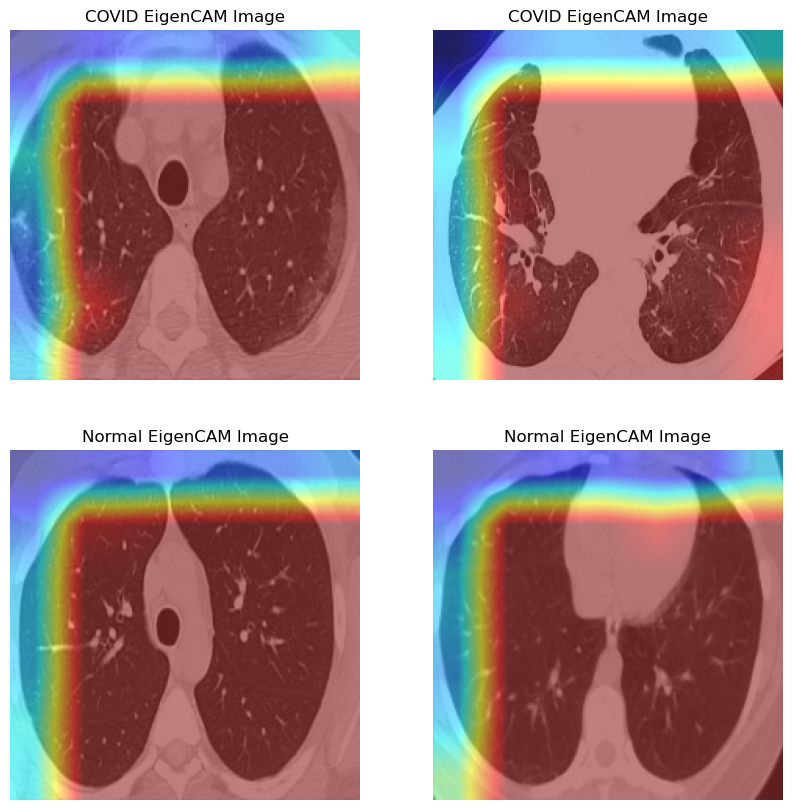

In [28]:
 # We have to specify the target we want to generate
    # the Class Activation Maps for.
    # If targets is None, the highest scoring category (for every member in the batch) will be used.
    # You can target specific categories by
    # targets = [e.g ClassifierOutputTarget(281)]
targets=None
# Decide how many images you want to display per row and column
# Separate the images based on their labels
covid_images = df[df['label'] == 1]['filename']
normal_images = df[df['label'] == 0]['filename']
rows = 2
cols = 2

# Create a figure and axes for the grid
fig, axs = plt.subplots(rows, cols, figsize=(10, 10))

# Display 2 COVID images
for col in range(cols):
    if col < len(covid_images):
        image_path = covid_images.iloc[col]

        rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
        rgb_img = np.float32(rgb_img) / 255
        input_tensor = preprocess_image(rgb_img,
                                        mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])

        # Using the with statement ensures the context is freed, and you can
        # recreate different CAM objects in a loop.
        cam_algorithm = methods[args.method]
        with cam_algorithm(model=model_2,
                        target_layers=target_layers_model_2,
                        use_cuda=args.use_cuda) as cam:

            cam.batch_size = 32
            grayscale_cam = cam(input_tensor=input_tensor,
                                targets=targets,
                                aug_smooth=args.aug_smooth,
                                eigen_smooth=args.eigen_smooth)

            grayscale_cam = grayscale_cam[0, :]
            cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
            # cam_image is RGB encoded whereas "cv2.imwrite" requires BGR encoding.
            cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)

        gb_model = GuidedBackpropReLUModel(model=model_2, use_cuda=args.use_cuda)
        gb = gb_model(input_tensor, target_category=None)

        cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
        cam_gb = deprocess_image(cam_mask * gb)
        gb = deprocess_image(gb)

        # Display the CAM image in the grid
        axs[0, col].imshow(cam_image)
        axs[0, col].axis('off')
        axs[0, col].set_title('COVID EigenCAM Image')

# Display 2 normal images
for col in range(cols):
    if col < len(normal_images):
        image_path = normal_images.iloc[col]

        rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
        rgb_img = np.float32(rgb_img) / 255
        input_tensor = preprocess_image(rgb_img,
                                        mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])

        # Using the with statement ensures the context is freed, and you can
        # recreate different CAM objects in a loop.
        cam_algorithm = methods[args.method]
        with cam_algorithm(model=model_2,
                        target_layers=target_layers_model_2,
                        use_cuda=args.use_cuda) as cam:

            cam.batch_size = 32
            grayscale_cam = cam(input_tensor=input_tensor,
                                targets=targets,
                                aug_smooth=args.aug_smooth,
                                eigen_smooth=args.eigen_smooth)

            grayscale_cam = grayscale_cam[0, :]
            cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
            # cam_image is RGB encoded whereas "cv2.imwrite" requires BGR encoding.
            cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)

        gb_model = GuidedBackpropReLUModel(model=model_2, use_cuda=args.use_cuda)
        gb = gb_model(input_tensor, target_category=None)

        cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
        cam_gb = deprocess_image(cam_mask * gb)
        gb = deprocess_image(gb)

        # Display the CAM image in the grid
        axs[1, col].imshow(cam_image)
        axs[1, col].axis('off')
        axs[1, col].set_title('Normal EigenCAM Image')
        
plt.show()

In [29]:
#Model 3 for GradCam Test Set

class Args:
    def __init__(self):
        self.use_cuda = False
        self.image_path = 'C:/Users/Mestr/Desktop/Intro to ML and Apps/Homework/hw5s/hw5s/COVID19CTS224/S224/COVID/Covid (1).png'
        self.csv_path = 'C:/Users/Mestr/Desktop/Intro to ML and Apps/Homework/hw5s/hw5s/COVID19CTS224/S224/test.csv'
        self.aug_smooth = False
        self.eigen_smooth = False
        self.method = 'gradcam'

args = Args()
methods ={"gradcam": GradCAM,
         "eigencam": EigenCAM}

# Load the CSV file
test_images = args.csv_path
df = pd.read_csv(test_images)

# Choose the target layer you want to compute the visualization for.
    # Usually this will be the last convolutional layer in the model.
    # Some common choices can be:
    # Resnet18 and 50: model.layer4
    # VGG, densenet161: model.features[-1]
    # mnasnet1_0: model.layers[-1]
    # You can print the model to help chose the layer
    # You can pass a list with several target layers,
    # in that case the CAMs will be computed per layer and then aggregated.
    # You can also try selecting all layers of a certain type, with e.g:
    # from pytorch_grad_cam.utils.find_layers import find_layer_types_recursive
    # find_layer_types_recursive(model, [torch.nn.ReLU])
target_layers_model_3 = [model_3.layer4]

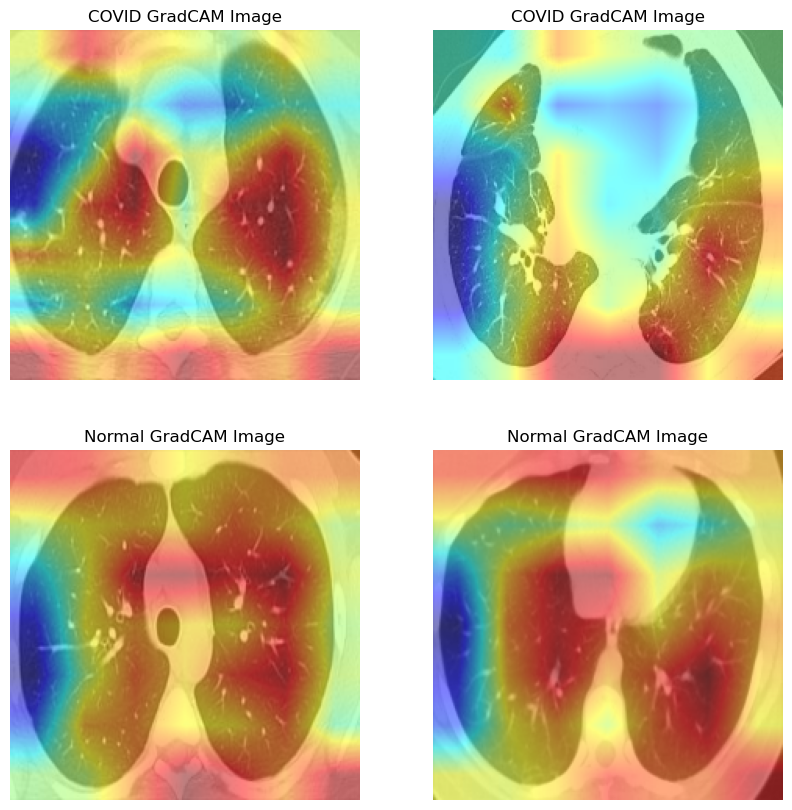

In [30]:
 # We have to specify the target we want to generate
    # the Class Activation Maps for.
    # If targets is None, the highest scoring category (for every member in the batch) will be used.
    # You can target specific categories by
    # targets = [e.g ClassifierOutputTarget(281)]
targets=None
# Decide how many images you want to display per row and column
# Separate the images based on their labels
covid_images = df[df['label'] == 1]['filename']
normal_images = df[df['label'] == 0]['filename']
rows = 2
cols = 2

# Create a figure and axes for the grid
fig, axs = plt.subplots(rows, cols, figsize=(10, 10))

# Display 2 COVID images
for col in range(cols):
    if col < len(covid_images):
        image_path = covid_images.iloc[col]

        rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
        rgb_img = np.float32(rgb_img) / 255
        input_tensor = preprocess_image(rgb_img,
                                        mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])

        # Using the with statement ensures the context is freed, and you can
        # recreate different CAM objects in a loop.
        cam_algorithm = methods[args.method]
        with cam_algorithm(model=model_3,
                        target_layers=target_layers_model_3,
                        use_cuda=args.use_cuda) as cam:

            cam.batch_size = 32
            grayscale_cam = cam(input_tensor=input_tensor,
                                targets=targets,
                                aug_smooth=args.aug_smooth,
                                eigen_smooth=args.eigen_smooth)

            grayscale_cam = grayscale_cam[0, :]
            cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
            # cam_image is RGB encoded whereas "cv2.imwrite" requires BGR encoding.
            cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)

        gb_model = GuidedBackpropReLUModel(model=model_3, use_cuda=args.use_cuda)
        gb = gb_model(input_tensor, target_category=None)

        cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
        cam_gb = deprocess_image(cam_mask * gb)
        gb = deprocess_image(gb)

        # Display the CAM image in the grid
        axs[0, col].imshow(cam_image)
        axs[0, col].axis('off')
        axs[0, col].set_title('COVID GradCAM Image')

# Display 2 normal images
for col in range(cols):
    if col < len(normal_images):
        image_path = normal_images.iloc[col]

        rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
        rgb_img = np.float32(rgb_img) / 255
        input_tensor = preprocess_image(rgb_img,
                                        mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])

        # Using the with statement ensures the context is freed, and you can
        # recreate different CAM objects in a loop.
        cam_algorithm = methods[args.method]
        with cam_algorithm(model=model_3,
                        target_layers=target_layers_model_3,
                        use_cuda=args.use_cuda) as cam:

            cam.batch_size = 32
            grayscale_cam = cam(input_tensor=input_tensor,
                                targets=targets,
                                aug_smooth=args.aug_smooth,
                                eigen_smooth=args.eigen_smooth)

            grayscale_cam = grayscale_cam[0, :]
            cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
            # cam_image is RGB encoded whereas "cv2.imwrite" requires BGR encoding.
            cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)

        gb_model = GuidedBackpropReLUModel(model=model_3, use_cuda=args.use_cuda)
        gb = gb_model(input_tensor, target_category=None)

        cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
        cam_gb = deprocess_image(cam_mask * gb)
        gb = deprocess_image(gb)

        # Display the CAM image in the grid
        axs[1, col].imshow(cam_image)
        axs[1, col].axis('off')
        axs[1, col].set_title('Normal GradCAM Image')
        
plt.show()

In [31]:
#Model 3 for EigenCam Test Set

class Args:
    def __init__(self):
        self.use_cuda = False
        self.image_path = 'C:/Users/Mestr/Desktop/Intro to ML and Apps/Homework/hw5s/hw5s/COVID19CTS224/S224/COVID/Covid (1).png'
        self.csv_path = 'C:/Users/Mestr/Desktop/Intro to ML and Apps/Homework/hw5s/hw5s/COVID19CTS224/S224/test.csv'
        self.aug_smooth = False
        self.eigen_smooth = False
        self.method = 'eigencam'

args = Args()
methods ={"gradcam": GradCAM,
         "eigencam": EigenCAM}

# Load the CSV file
test_images = args.csv_path
df = pd.read_csv(test_images)

# Choose the target layer you want to compute the visualization for.
    # Usually this will be the last convolutional layer in the model.
    # Some common choices can be:
    # Resnet18 and 50: model.layer4
    # VGG, densenet161: model.features[-1]
    # mnasnet1_0: model.layers[-1]
    # You can print the model to help chose the layer
    # You can pass a list with several target layers,
    # in that case the CAMs will be computed per layer and then aggregated.
    # You can also try selecting all layers of a certain type, with e.g:
    # from pytorch_grad_cam.utils.find_layers import find_layer_types_recursive
    # find_layer_types_recursive(model, [torch.nn.ReLU])
target_layers_model_3 = [model_3.layer4]

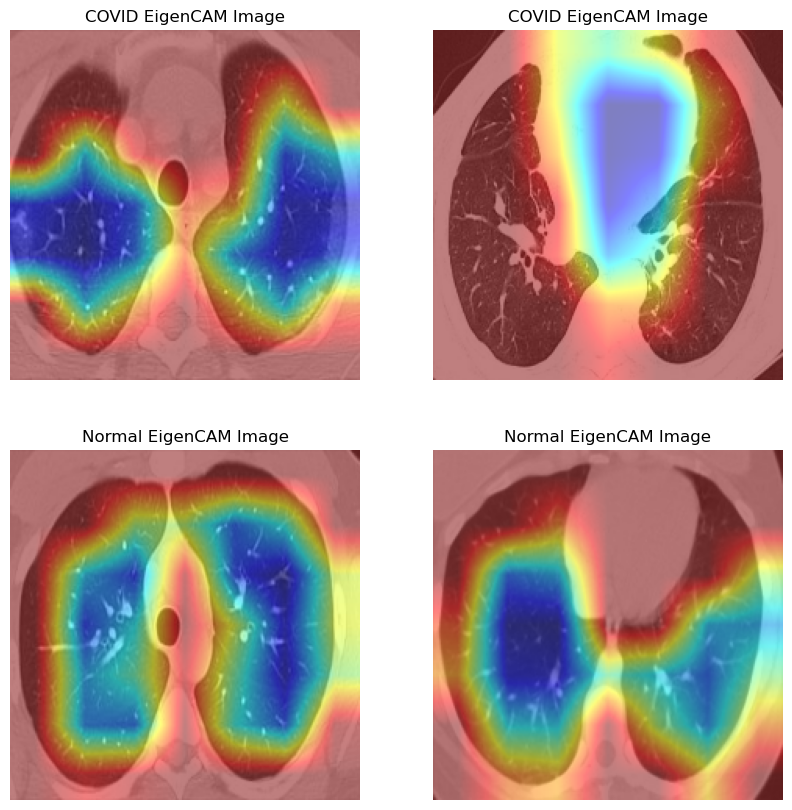

In [32]:
 # We have to specify the target we want to generate
    # the Class Activation Maps for.
    # If targets is None, the highest scoring category (for every member in the batch) will be used.
    # You can target specific categories by
    # targets = [e.g ClassifierOutputTarget(281)]
targets=None
# Decide how many images you want to display per row and column
# Separate the images based on their labels
covid_images = df[df['label'] == 1]['filename']
normal_images = df[df['label'] == 0]['filename']
rows = 2
cols = 2

# Create a figure and axes for the grid
fig, axs = plt.subplots(rows, cols, figsize=(10, 10))

# Display 2 COVID images
for col in range(cols):
    if col < len(covid_images):
        image_path = covid_images.iloc[col]

        rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
        rgb_img = np.float32(rgb_img) / 255
        input_tensor = preprocess_image(rgb_img,
                                        mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])

        # Using the with statement ensures the context is freed, and you can
        # recreate different CAM objects in a loop.
        cam_algorithm = methods[args.method]
        with cam_algorithm(model=model_3,
                        target_layers=target_layers_model_3,
                        use_cuda=args.use_cuda) as cam:

            cam.batch_size = 32
            grayscale_cam = cam(input_tensor=input_tensor,
                                targets=targets,
                                aug_smooth=args.aug_smooth,
                                eigen_smooth=args.eigen_smooth)

            grayscale_cam = grayscale_cam[0, :]
            cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
            # cam_image is RGB encoded whereas "cv2.imwrite" requires BGR encoding.
            cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)

        gb_model = GuidedBackpropReLUModel(model=model_3, use_cuda=args.use_cuda)
        gb = gb_model(input_tensor, target_category=None)

        cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
        cam_gb = deprocess_image(cam_mask * gb)
        gb = deprocess_image(gb)

        # Display the CAM image in the grid
        axs[0, col].imshow(cam_image)
        axs[0, col].axis('off')
        axs[0, col].set_title('COVID EigenCAM Image')

# Display 2 normal images
for col in range(cols):
    if col < len(normal_images):
        image_path = normal_images.iloc[col]

        rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
        rgb_img = np.float32(rgb_img) / 255
        input_tensor = preprocess_image(rgb_img,
                                        mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])

        # Using the with statement ensures the context is freed, and you can
        # recreate different CAM objects in a loop.
        cam_algorithm = methods[args.method]
        with cam_algorithm(model=model_3,
                        target_layers=target_layers_model_3,
                        use_cuda=args.use_cuda) as cam:

            cam.batch_size = 32
            grayscale_cam = cam(input_tensor=input_tensor,
                                targets=targets,
                                aug_smooth=args.aug_smooth,
                                eigen_smooth=args.eigen_smooth)

            grayscale_cam = grayscale_cam[0, :]
            cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
            # cam_image is RGB encoded whereas "cv2.imwrite" requires BGR encoding.
            cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)

        gb_model = GuidedBackpropReLUModel(model=model_3, use_cuda=args.use_cuda)
        gb = gb_model(input_tensor, target_category=None)

        cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
        cam_gb = deprocess_image(cam_mask * gb)
        gb = deprocess_image(gb)

        # Display the CAM image in the grid
        axs[1, col].imshow(cam_image)
        axs[1, col].axis('off')
        axs[1, col].set_title('Normal EigenCAM Image')
        
plt.show()

In [33]:
# Code about the Gradcam and Eigencam were inspired by https://github.com/jacobgil/pytorch-grad-cam